In [1]:
import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
import plotly.graph_objects as go # gráficos 3D
from scipy.stats import pearsonr # correlações de Pearson
import statsmodels.api as sm # estimação de modelos
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from sklearn.preprocessing import LabelEncoder # transformação de dados
import pingouin as pg # outro modo para obtenção de matrizes de correlações
import emojis # inserção de emojis em gráficos
from statstests.process import stepwise # procedimento Stepwise
from statstests.tests import shapiro_francia # teste de Shapiro-Francia
from scipy.stats import boxcox # transformação de Box-Cox
from scipy.stats import norm # para plotagem da curva normal
from scipy import stats # utilizado na definição da função 'breusch_pagan_test'

In [2]:
# Carregando Dados
df_corrupcao = pd.read_csv('../data/corrupcao.csv',delimiter=',',encoding='utf-8')

# Características das variáveis do dataset
df_corrupcao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pais    50 non-null     object 
 1   cpi     50 non-null     float64
 2   regiao  50 non-null     object 
dtypes: float64(1), object(2)
memory usage: 1.3+ KB


In [3]:
# Estatísticas univariadas
df_corrupcao.describe()

,cpi
count,50.000000
mean,4.894000
std,2.678974
min,0.800000
25%,2.575000
50%,3.950000
75%,7.475000
max,9.300000


In [4]:
# Estatísticas univariadas por região
df_corrupcao.groupby('regiao').describe()

cpi                                                  
               count      mean       std  min    25%   50%    75%  max
regiao                                                                
America_do_sul   5.0  4.180000  1.237740  2.8  3.900  4.00  4.000  6.2
Asia            17.0  2.329412  0.898446  0.8  1.800  2.30  2.800  3.8
EUA_e_Canada     2.0  8.000000  1.272792  7.1  7.550  8.00  8.450  8.9
Europa          24.0  6.258333  2.272504  2.1  4.275  6.55  8.125  9.3
Oceania          2.0  9.000000  0.424264  8.7  8.850  9.00  9.150  9.3

In [7]:
# Tabela de frequências da variável 'regiao'
contagem = df_corrupcao['regiao'].value_counts(dropna=False)
percent = df_corrupcao['regiao'].value_counts(dropna=False, normalize=True)
pd.concat([contagem, percent], axis=1, keys=['contagem', '%'], sort=False).reset_index()

,regiao,contagem,%
0,Europa,24,0.48
1,Asia,17,0.34
2,America_do_sul,5,0.10
3,Oceania,2,0.04
4,EUA_e_Canada,2,0.04


In [8]:
# Conversão dos dados de 'regiao' para dados numéricos, a fim de
# se mostrar a estimação de modelo com o problema da ponderação arbitrária
# ERRADO, SOMENTE PARA EXEMPLO COM A FORMA CORRETA POSTERIORMENTE

label_encoder = LabelEncoder()
df_corrupcao['regiao_numerico'] = label_encoder.fit_transform(df_corrupcao['regiao'])
df_corrupcao['regiao_numerico'] = df_corrupcao['regiao_numerico'] + 1
df_corrupcao.head(10)

,pais,cpi,regiao,regiao_numerico
0,Argentina,3.9,America_do_sul,1
1,Australia,8.7,Oceania,5
2,Austria,7.9,Europa,4
3,Belgium,7.1,Europa,4
4,Brazil,4.0,America_do_sul,1
5,Canada,8.9,EUA_e_Canada,3
6,Chile,6.2,America_do_sul,1
7,China,2.5,Asia,2
8,Colombia,4.0,America_do_sul,1
9,Cyprus,6.3,Europa,4


In [9]:
# A nova variável 'regiao_numerico' é quantitativa (ERRO!), fato que
# caracteriza a ponderação arbitrária!
df_corrupcao['regiao_numerico'].info()
df_corrupcao.describe()

<class 'pandas.core.series.Series'>
RangeIndex: 50 entries, 0 to 49
Series name: regiao_numerico
Non-Null Count  Dtype
--------------  -----
50 non-null     int64
dtypes: int64(1)
memory usage: 532.0 bytes


,cpi,regiao_numerico
count,50.000000,50.000000
mean,4.894000,3.020000
std,2.678974,1.186489
min,0.800000,1.000000
25%,2.575000,2.000000
50%,3.950000,4.000000
75%,7.475000,4.000000
max,9.300000,5.000000


In [10]:
# Modelando com a variável preditora numérica, resultando na
# estimação ERRADA dos parâmetros
# PONDERAÇÃO ARBITRÁRIA!
modelo_corrupcao_errado = sm.OLS.from_formula("cpi ~ regiao_numerico",
                                              df_corrupcao).fit()

# Parâmetros do 'modelo_corrupcao_errado'
print(modelo_corrupcao_errado.summary())

                            OLS Regression Results                            
Dep. Variable:                    cpi   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     33.56
Date:                Sat, 10 Aug 2024   Prob (F-statistic):           5.19e-07
Time:                        09:05:34   Log-Likelihood:                -106.46
No. Observations:                  50   AIC:                             216.9
Df Residuals:                      48   BIC:                             220.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5200      0.810     

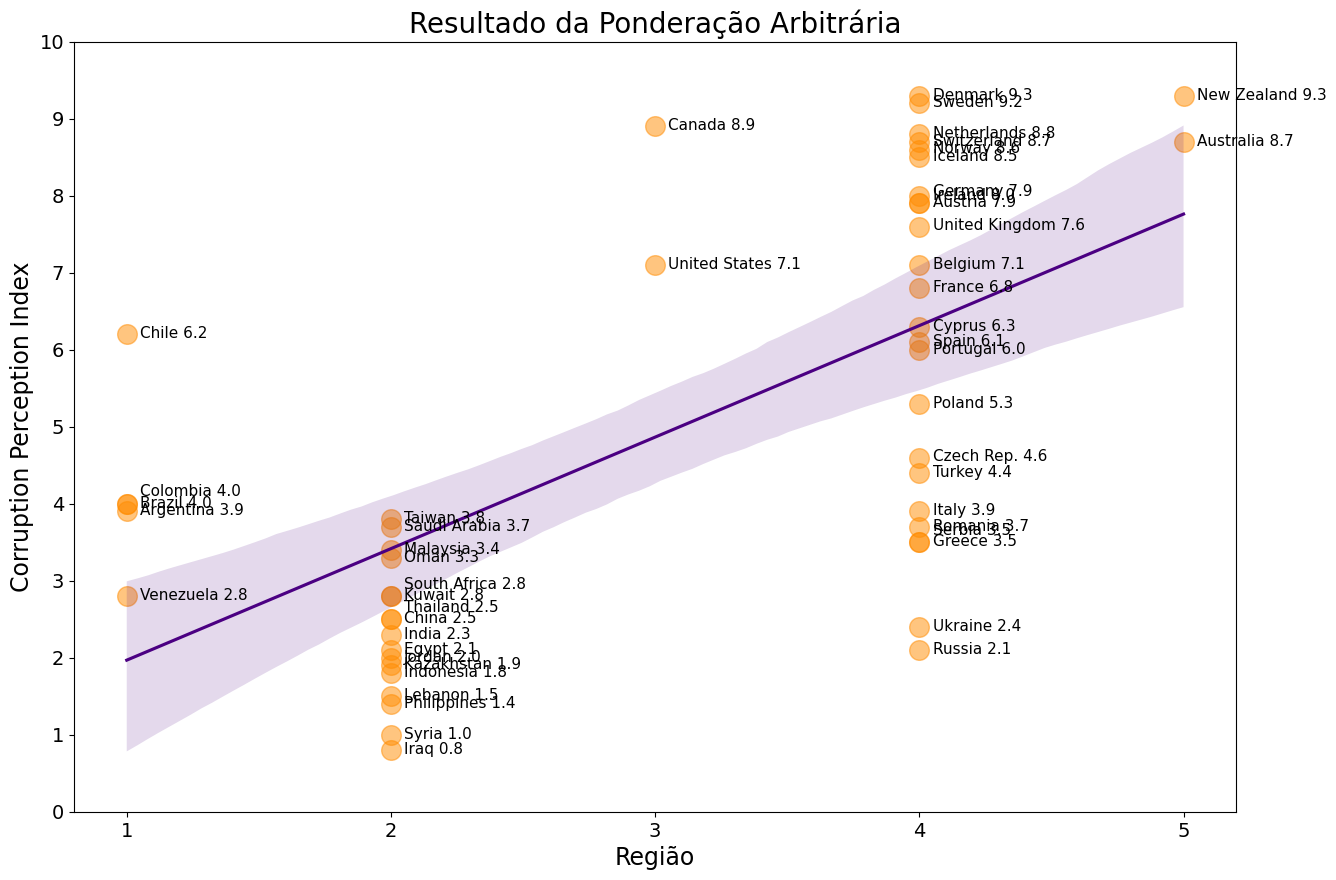

In [11]:
# Plotando os fitted values do 'modelo_corrupcao_errado' considerando,
# PROPOSITALMENTE, a ponderação arbitrária, ou seja, assumindo que as regiões
# representam valores numéricos (América do Sul = 1; Ásia = 2; EUA e Canadá = 3;
# Europa = 4; Oceania = 5).

plt.figure(figsize=(15,10))

ax =sns.regplot(
    data=df_corrupcao,
    x="regiao_numerico", y="cpi",
    scatter_kws={"s": 200, "color": "darkorange", "alpha": 0.5},
    line_kws={"color": "indigo"}
)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        offset = 0
        while ax.texts:
            overlapping = False
            for text in ax.texts:
                overlapping |= text.get_position()[0] == (point['x'] + 0.05) and text.get_position()[1] == (point['y'] - 0.05 + offset)
            if overlapping:
                offset += 0.15
            else:
                break
        ax.annotate(str(point['val']) + " " + str(point['y']),
                    (point['x'] + 0.05,
                     point['y'] - 0.05 + offset),
                    fontsize=11)
                
plt.title('Resultado da Ponderação Arbitrária', fontsize=20)
plt.xlabel('Região', fontsize=17)
plt.ylabel('Corruption Perception Index', fontsize=17)
plt.xticks(range(1, 6, 1), fontsize=14)
plt.yticks(range(0, 11, 1), fontsize=14)
label_point(x = df_corrupcao['regiao_numerico'],
            y = df_corrupcao['cpi'],
            val = df_corrupcao['pais'],
            ax = plt.gca())
plt.show()

**Dummizando a variável 'regiao'. O código abaixo automaticamente fará:**

    a) o estabelecimento de dummies que representarão cada uma das regiões do dataset;
    b) removerá a variável original a partir da qual houve a dummização;
    c) estabelecerá como categoria de referência a primeira categoria, ou seja, a categoria 'America_do_sul' por meio do argumento 'drop_first=True'.

In [21]:
df_corrupcao_dummies = pd.get_dummies(df_corrupcao, columns=['regiao'],
                                      dtype=int,
                                      drop_first=True)

# A variável 'regiao' estava inicialmente definida como 'object' no dataframe
# original 'df_corrupcao'
df_corrupcao['regiao'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 50 entries, 0 to 49
Series name: regiao
Non-Null Count  Dtype 
--------------  ----- 
50 non-null     object
dtypes: object(1)
memory usage: 532.0+ bytes


*Este procedimento de dummização também poderia ter sido realizado em uma variável do tipo 'category' ou 'string'!*

 - Racional da transformação da categoria em dummy:

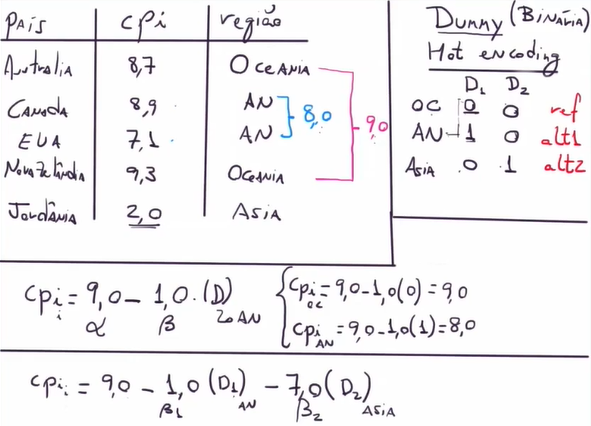

In [14]:
# Estimação do modelo de regressão múltipla com n-1 dummies

modelo_corrupcao_dummies = sm.OLS.from_formula("cpi ~ regiao_Asia + \
                                              regiao_EUA_e_Canada + \
                                              regiao_Europa + \
                                              regiao_Oceania",
                                              df_corrupcao_dummies).fit()

# Parâmetros do 'modelo_corrupcao_dummies'
print(modelo_corrupcao_dummies.summary())

                            OLS Regression Results                            
Dep. Variable:                    cpi   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     17.09
Date:                Sat, 10 Aug 2024   Prob (F-statistic):           1.37e-08
Time:                        10:06:21   Log-Likelihood:                -96.620
No. Observations:                  50   AIC:                             203.2
Df Residuals:                      45   BIC:                             212.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               4.1800    

In [15]:
df_corrupcao.groupby('regiao')['cpi'].mean()

regiao
America_do_sul    4.180000
Asia              2.329412
EUA_e_Canada      8.000000
Europa            6.258333
Oceania           9.000000
Name: cpi, dtype: float64

*Obs.: O valor da média da América do Sul (Categoria dropada pelo parâmetro drop_first) é o valor do intercept, e todos os betas são o resultado da média da categoria menos o intercept.*

```Exemplo: Asia = 2.32 - 4.18 = -1.85```

In [16]:
# Outro método de estimação (sugestão de uso para muitas dummies no dataset)

# Definição da fórmula utilizada no modelo
lista_colunas = list(df_corrupcao_dummies.drop(columns=['cpi','pais',
                                                        'regiao_numerico']).columns)
formula_dummies_modelo = ' + '.join(lista_colunas)
formula_dummies_modelo = "cpi ~ " + formula_dummies_modelo
print("Fórmula utilizada: ",formula_dummies_modelo)

# Estimação
modelo_corrupcao_dummies = sm.OLS.from_formula(formula_dummies_modelo,
                                               df_corrupcao_dummies).fit()

# Parâmetros do 'modelo_corrupcao_dummies'
print(modelo_corrupcao_dummies.summary())

Fórmula utilizada:  cpi ~ regiao_Asia + regiao_EUA_e_Canada + regiao_Europa + regiao_Oceania
                            OLS Regression Results                            
Dep. Variable:                    cpi   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     17.09
Date:                Sat, 10 Aug 2024   Prob (F-statistic):           1.37e-08
Time:                        10:14:07   Log-Likelihood:                -96.620
No. Observations:                  50   AIC:                             203.2
Df Residuals:                      45   BIC:                             212.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [17]:
# Plotando o 'modelo_corrupcao_dummies' de forma interpolada

# Fitted values do 'modelo_corrupcao_dummies' no dataset 'df_corrupcao_dummies'
df_corrupcao_dummies['fitted'] = modelo_corrupcao_dummies.fittedvalues
df_corrupcao_dummies

,pais,cpi,regiao_numerico,regiao_Asia,regiao_EUA_e_Canada,regiao_Europa,regiao_Oceania,fitted
0,Argentina,3.9,1,0,0,0,0,4.180000
1,Australia,8.7,5,0,0,0,1,9.000000
2,Austria,7.9,4,0,0,1,0,6.258333
3,Belgium,7.1,4,0,0,1,0,6.258333
4,Brazil,4.0,1,0,0,0,0,4.180000
5,Canada,8.9,3,0,1,0,0,8.000000
6,Chile,6.2,1,0,0,0,0,4.180000
7,China,2.5,2,1,0,0,0,2.329412
8,Colombia,4.0,1,0,0,0,0,4.180000
9,Cyprus,6.3,4,0,0,1,0,6.258333


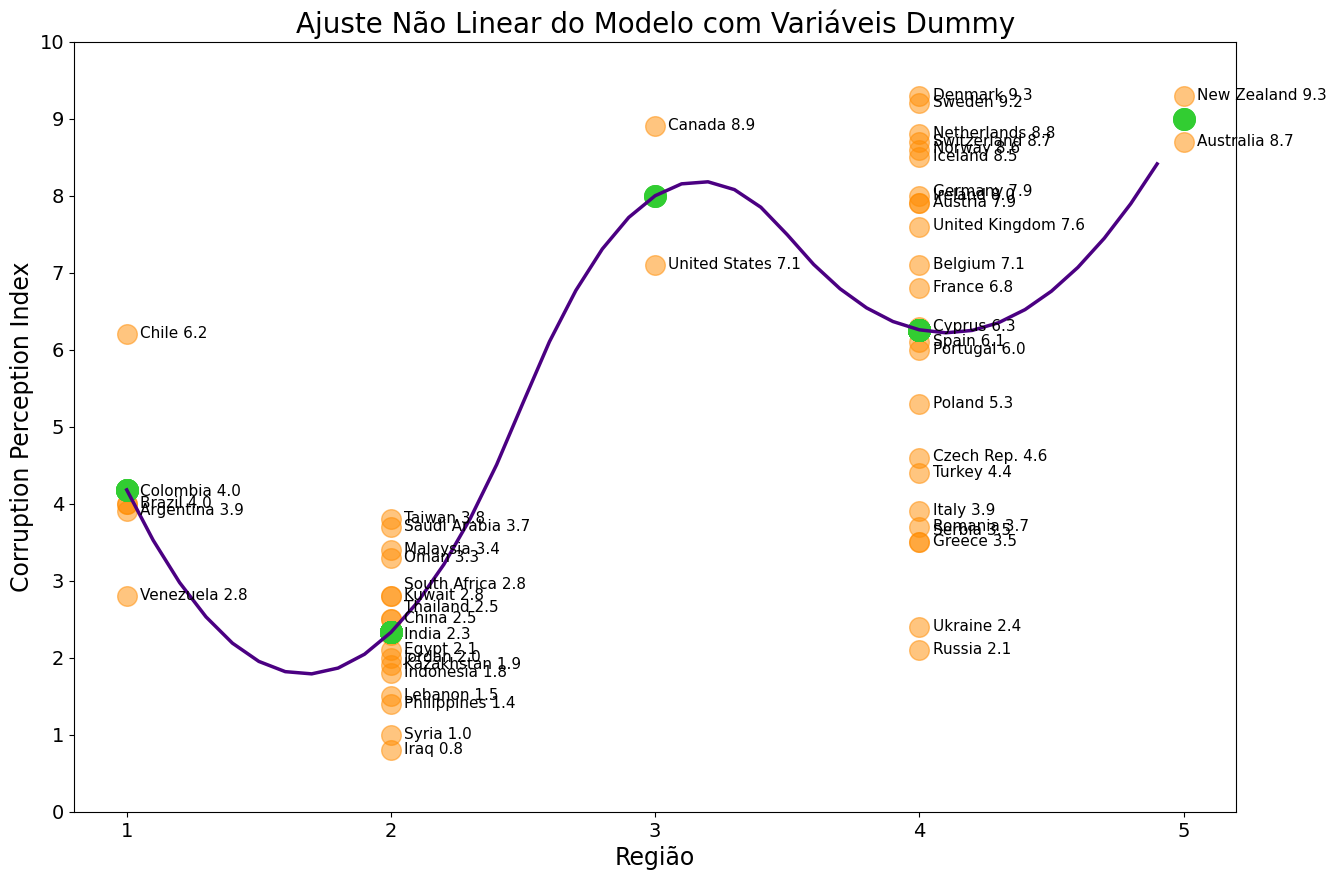

In [18]:
# Gráfico propriamente dito

from scipy import interpolate

plt.figure(figsize=(15, 10))

df2 = df_corrupcao_dummies[['regiao_numerico',
                            'fitted']].groupby(['regiao_numerico']).median().reset_index()
x = df2['regiao_numerico']
y = df2['fitted']

tck = interpolate.splrep(x, y, k=2)
xnew = np.arange(1, 5, 0.1)
ynew = interpolate.splev(xnew, tck, der=0)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        offset = 0
        while ax.texts:
            overlapping = False
            for text in ax.texts:
                overlapping |= text.get_position()[0] == (point['x'] + 0.05) and text.get_position()[1] == (point['y'] - 0.05 + offset)
            if overlapping:
                offset += 0.15
            else:
                break
        ax.annotate(str(point['val']) + " " + str(point['y']),
                    (point['x'] + 0.05,
                     point['y'] - 0.05 + offset),
                    fontsize=11)

plt.scatter(df_corrupcao_dummies['regiao_numerico'],
            df_corrupcao_dummies['cpi'], color='darkorange', s=200, alpha=0.5)
plt.scatter(df_corrupcao_dummies['regiao_numerico'],
            df_corrupcao_dummies['fitted'], color='limegreen', s=240)
plt.plot(xnew, ynew, color='indigo', linewidth=2.5)
plt.title('Ajuste Não Linear do Modelo com Variáveis Dummy', fontsize=20)
plt.xlabel('Região', fontsize=17)
plt.ylabel('Corruption Perception Index', fontsize=17)
plt.xticks(range(1, 6, 1), fontsize=14)
plt.yticks(range(0, 11, 1), fontsize=14)
label_point(x=df_corrupcao_dummies['regiao_numerico'],
            y=df_corrupcao_dummies['cpi'],
            val=df_corrupcao_dummies['pais'],
            ax=plt.gca())
plt.show()

In [20]:
# Gráfico com interação
df2 = df_corrupcao_dummies[['regiao_numerico',
                            'fitted']].groupby(['regiao_numerico']).median().reset_index()
x = df2['regiao_numerico']
y = df2['fitted']

tck = interpolate.splrep(x, y, k=2)
xnew = np.arange(1, 5, 0.1)
ynew = interpolate.splev(xnew, tck, der=0)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_corrupcao_dummies['regiao_numerico'],
    y=df_corrupcao_dummies['cpi'],
    mode='markers',
    name='CPI',
    marker=dict(color='darkorange', size=14, opacity=0.5)
))

fig.add_trace(go.Scatter(
    x=df_corrupcao_dummies['regiao_numerico'],
    y=df_corrupcao_dummies['fitted'],
    mode='markers',
    name='Fitted',
    marker=dict(color='limegreen', size=17)
))

fig.add_trace(go.Scatter(
    x=xnew,
    y=ynew,
    mode='lines',
    name='Interpolated',
    line=dict(color='indigo', width=3.5)
))

fig.update_layout(title={
        'text': 'Ajuste Não Linear do Modelo com Variáveis Dummy (Interativo)',
        'font': {'size': 20, 'color': 'black', 'family': 'Arial'},
        'x': 0.5,
        'y': 0.95,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis=dict(title='Região'),
    yaxis=dict(title='Corruption Perception Index'),
    xaxis_tickvals=list(range(1, 6)),
    yaxis_tickvals=list(range(0, 11)),
    xaxis_tickfont=dict(size=14),
    yaxis_tickfont=dict(size=14),
    template='plotly_white')

for i in range(len(df_corrupcao_dummies)):
    fig.add_annotation(
        x=df_corrupcao_dummies['regiao_numerico'][i],
        y=df_corrupcao_dummies['cpi'][i],
        text=str(df_corrupcao_dummies['pais'][i]) + ' ' + str(df_corrupcao_dummies['cpi'][i]),
        showarrow=False,
        font=dict(size=11, color='black'),
        xshift=50,
        yshift=0,
        textangle=0
    )

fig.update_annotations(dict(xref="x", yref="y"))
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

fig.show()

In [22]:
# Mudando a Categoria de Referencia para Oceania
df_corrupcao_dummies = pd.get_dummies(df_corrupcao, columns=['regiao'],
                                      dtype=int,
                                      drop_first=False)

# Definição da fórmula utilizada no modelo
lista_colunas = list(df_corrupcao_dummies.drop(columns=['cpi','pais',
                                                        'regiao_numerico',
                                                        'regiao_Oceania']).columns)
formula_dummies_modelo = ' + '.join(lista_colunas)
formula_dummies_modelo = "cpi ~ " + formula_dummies_modelo
print("Fórmula utilizada: ",formula_dummies_modelo)

# Estimação
modelo_corrupcao_dummies = sm.OLS.from_formula(formula_dummies_modelo,
                                               df_corrupcao_dummies).fit()

# Parâmetros do 'modelo_corrupcao_dummies'
print(modelo_corrupcao_dummies.summary())

Fórmula utilizada:  cpi ~ regiao_America_do_sul + regiao_Asia + regiao_EUA_e_Canada + regiao_Europa
                            OLS Regression Results                            
Dep. Variable:                    cpi   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     17.09
Date:                Sat, 10 Aug 2024   Prob (F-statistic):           1.37e-08
Time:                        10:23:23   Log-Likelihood:                -96.620
No. Observations:                  50   AIC:                             203.2
Df Residuals:                      45   BIC:                             212.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------